# S08 T01: Tasca del test d'hipòtesis
**Descripció**

Aprèn a realitzar test d'hipòtesis amb Python.

## Nivell 1
### - Exercici 1

Agafa un conjunt de dades de tema esportiu que t'agradi i selecciona un atribut del conjunt de dades. Calcula el p-valor i digues si rebutja la hipòtesi nul·la agafant un alfa de 5%. 



In [1]:
## Carga librerías
import pandas as pd
import numpy as np

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns


import pingouin as pg
from scipy.stats import shapiro


Para este ejercicio voy a utilizar una dataset con información sobre jugadores de la NBA.  

Podemos descargar este dataset de Kaggle, [NBA Players stats since 1950](https://www.kaggle.com/drgilermo/nba-players-stats)  

Este dataset contiene tres tablas, en nuestro caso vamos a utilizar la tabla, _"player-data.csv"_. En esta tabla tenemos recogida información sobre las siguientes variables:


```
   1 - Player. Nombre 
   2 - Year Start
   3 - Year End
   4 - Position - Puesto 
   5 - Height. Altura en pies - pulgada
   6 - Weight. Peso en libras
   7 - Birth Date. Año de nacimiento
   8 - College. Universidad de precedencia
     
```




In [5]:
# Carga Archivo
NBA=pd.read_csv('./datasets/player_data.csv',sep=',')


In [3]:
NBA.head()

,name,year_start,year_end,position,height,weight,birth_date,college
0,Alaa Abdelnaby,1991,1995,F-C,6-10,240.0,"June 24, 1968",Duke University
1,Zaid Abdul-Aziz,1969,1978,C-F,6-9,235.0,"April 7, 1946",Iowa State University
2,Kareem Abdul-Jabbar,1970,1989,C,7-2,225.0,"April 16, 1947","University of California, Los Angeles"
3,Mahmoud Abdul-Rauf,1991,2001,G,6-1,162.0,"March 9, 1969",Louisiana State University
4,Tariq Abdul-Wahad,1998,2003,F,6-6,223.0,"November 3, 1974",San Jose State University


In [6]:
NBA.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4550 entries, 0 to 4549
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        4550 non-null   object 
 1   year_start  4550 non-null   int64  
 2   year_end    4550 non-null   int64  
 3   position    4549 non-null   object 
 4   height      4549 non-null   object 
 5   weight      4544 non-null   float64
 6   birth_date  4519 non-null   object 
 7   college     4248 non-null   object 
dtypes: float64(1), int64(2), object(5)
memory usage: 284.5+ KB


A continuación voy a limpiar el dataset, eliminando las observaciones con valores nulos de altura, PESO O FECHA DE NACIMIENTO y asignando un valor _"Unknown"_ a las observaciones desconocidas de colegio de procedencia.

In [7]:
# Drop missing Values at height, weight and birth_date
NBA.dropna(subset = ['height','weight','birth_date'],
           inplace = True)

In [8]:
# Set missing_values as Unknown at college
NBA.loc[NBA.college.isna(), 'college'] = 'Unknown'

In [9]:
# Drop duplicates in case they exists
NBA.drop_duplicates(inplace = True)

In [10]:
NBA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4514 entries, 0 to 4549
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        4514 non-null   object 
 1   year_start  4514 non-null   int64  
 2   year_end    4514 non-null   int64  
 3   position    4514 non-null   object 
 4   height      4514 non-null   object 
 5   weight      4514 non-null   float64
 6   birth_date  4514 non-null   object 
 7   college     4514 non-null   object 
dtypes: float64(1), int64(2), object(5)
memory usage: 317.4+ KB


In [11]:
NBA.reset_index(inplace = True)

Ahora convierto altura a metros y peso a Kg y estrago el año de nacimiento y el número de temporadas que jugaron.

In [12]:
# Transformo altura a metros

NBA['height_m'] = round( NBA.height.str.split('-',expand = True).astype(float)[0]*0.3048 
                        + NBA.height.str.split('-',expand = True)[1].astype(float)*0.0254,
                        2)


# Transformo peso a kg

NBA['weight_kg'] = round( NBA.weight*0.4536,1)


In [13]:
# Extraigo año nacimiento

NBA['birth_year'] = NBA.birth_date.str.split(',',expand = True)[1].astype(int)

In [14]:
NBA['Num_seasons'] = NBA.year_end - NBA.year_start

In [15]:
NBA.head()

,index,name,year_start,year_end,position,height,weight,birth_date,college,height_m,weight_kg,birth_year,Num_seasons
0,0,Alaa Abdelnaby,1991,1995,F-C,6-10,240.0,"June 24, 1968",Duke University,2.08,108.9,1968,4
1,1,Zaid Abdul-Aziz,1969,1978,C-F,6-9,235.0,"April 7, 1946",Iowa State University,2.06,106.6,1946,9
2,2,Kareem Abdul-Jabbar,1970,1989,C,7-2,225.0,"April 16, 1947","University of California, Los Angeles",2.18,102.1,1947,19
3,3,Mahmoud Abdul-Rauf,1991,2001,G,6-1,162.0,"March 9, 1969",Louisiana State University,1.85,73.5,1969,10
4,4,Tariq Abdul-Wahad,1998,2003,F,6-6,223.0,"November 3, 1974",San Jose State University,1.98,101.2,1974,5


Y por último selecciono los campos con lo que voy a trabajar.

In [16]:
NBA_hipotesis = NBA[['name', 'height_m', 'weight_kg', 'birth_year', 'Num_seasons', 'position']]
NBA_hipotesis

,name,height_m,weight_kg,birth_year,Num_seasons,position
0,Alaa Abdelnaby,2.08,108.9,1968,4,F-C
1,Zaid Abdul-Aziz,2.06,106.6,1946,9,C-F
2,Kareem Abdul-Jabbar,2.18,102.1,1947,19,C
3,Mahmoud Abdul-Rauf,1.85,73.5,1969,10,G
4,Tariq Abdul-Wahad,1.98,101.2,1974,5,F
...,...,...,...,...,...,...
4509,Ante Zizic,2.11,113.4,1997,0,F-C
4510,Jim Zoet,2.16,108.9,1953,0,C
4511,Bill Zopf,1.85,77.1,1948,0,G
4512,Ivica Zubac,2.16,120.2,1997,1,C


### EDA.

Hagamos un análisis rápido de las distribuciones de nuestras variables con el método describe().

In [17]:
NBA_hipotesis.describe()

,height_m,weight_kg,birth_year,Num_seasons
count,4514.000000,4514.000000,4514.000000,4514.000000
mean,1.982619,94.792667,1961.320780,4.228401
std,0.092457,11.937526,21.647087,4.506330
min,1.600000,51.700000,1902.000000,0.000000
25%,1.910000,86.200000,1946.000000,0.000000
50%,1.980000,95.300000,1963.000000,3.000000
75%,2.060000,102.100000,1980.000000,7.000000
max,2.310000,163.300000,1998.000000,22.000000


Perfecto, vemos que la altura media de nuestra población es 1,98 y que media y mediana para el caso de altura son casi iguales.

El peso medio está en una 94,7 kg y los judaores juegan un promedio de 4 temporadas, aunquehay algunos casos de hasta 22 temporadas.

Vamos a ver a continuación los histogramas de nuestras distribuciones. 

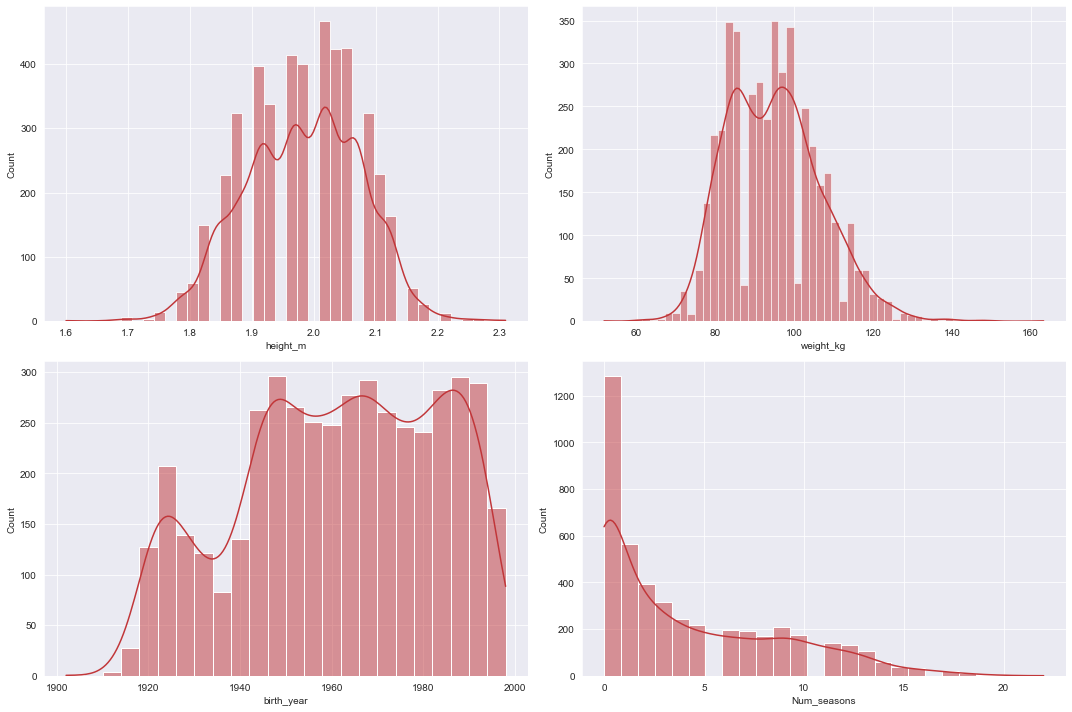

In [20]:
# Representación gráfica histogramas con (kde) de las features numéricas
#---------------------------------------------------------------------------
filas=2
columnas=2

fig, axes = plt.subplots(filas, columnas, figsize=(15, 10),tight_layout=True)

sns.set_style("darkgrid")
sns.set_palette('RdGy')

for i in range(filas):
    for j in range(columnas):

        var=(+j)+(i*columnas)
        
        sns.histplot(ax = axes[i, j], 
                     data = NBA_hipotesis,  
                     x = NBA_hipotesis.columns[var+1],
                     bins = 'auto',
                     kde = True,
                     alpha = 0.5)
        

El peso y la altura tienen una distribución que parece que podría ser gausiana. 

Por otro lado si vemos el año de nacimiento de nuestros jugadores, se observa una tendencia constante entre mediados de los 1940 y los 2000 de unos 125 jugares / año y esa tendencia es menor para fechas anteriores a 1940, tal vez estará relacionado con el de equipos que jugaban en las primeras temporadas de la NBA.

Si miramos la distribución de temporadas vemos que mantenerse en activo más de 3 años en la mejor liga del mundo es muy difícil y solo lo consiguen el 50 % de los jugadores.

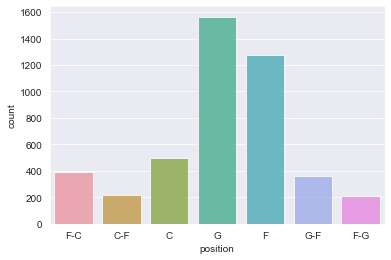

In [26]:
# Número de jugadores por posición
sns.countplot(data = NBA_hipotesis,  
             x = NBA_hipotesis.position,
             alpha = 0.8);

**Hipótesis 1**

Voy a tomar una muestra del 5% y quiero saber si la distribución de la altura en mi muestra es representativa.

En este caso la hipótesis quedaría formulada como sigue:

$H_0: \overline{X}_{(muestra-jugadores)} = \mu_{(población-jugadores)}$

$H_A: \overline{X}_{(muestra-jugadores)} \neq \mu_{población-jugadores)}$

In [27]:
# Voy a trabajar con una muestra del 5 %
muestra = NBA_hipotesis.sample(frac = 0.05,
                       random_state = 1984)

In [28]:
muestra.height_m.mean()

1.9832300884955751

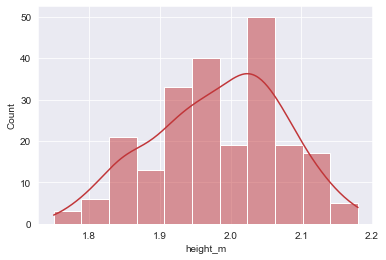

In [29]:
sns.histplot(data=muestra,  
             x='height_m',
             kde=True,
             alpha=0.5);

In [30]:
# Test de normalidad
shapiro(muestra.height_m)

ShapiroResult(statistic=0.9795364141464233, pvalue=0.002321604173630476)

Aplicando el test de Shapiro como p<0.05 obtengo que no puedo descartar que la distribución no sea normal.

Por lo tanto no estaría cumpliento las condiciones para aplicar el t-test para comparación de poblaciones. Aunque en a nivel de resultados está demostrado empíricamente que los resultados son similares, vamos a probar nuestra hipótesis con un test no paramétrico. En este caso Mann-Whitney U Test (= Wilcoxon rank-sum test), que sería la versión no-paramétrica del T-test para muestras independientes.


In [31]:
# Man - Whitney U Test
pg.mwu(x = muestra.height_m,
       y = NBA_hipotesis.height_m,
       tail = 'two-sided')

,U-val,tail,p-val,RBC,CLES
MWU,516102.5,two-sided,0.763552,-0.011803,0.505902


P - Value > 0.05 - Como el valor p es mayor que el nivel de significancia, no puedo rechazar la hipótesis nula, por lo que **puedo afirmar que las medias son iguales**.

En este primer caso hemos aplicado un test de dos colas, vamos a plicar ahora un test de una cola para responder a la pregunta sobre si los jugadores de la década de los 90, son más altos que el resto. 

En el siguiente caso quiero saber si existe evidencia estadística para afirmar que la altura de los jugadores nacidos en los 90's es mayor que la media de todos los jugadores.

En este caso tendríamos que aplicar un **test de una cola**. Y la formulación de la hipótesis sería:

$H_0: \mu_{(jugadores-90's)} \leqslant \mu_{(resto-jugadores)}$

$H_A: \mu_{(jugadores-90's)} > \mu_{(resto-jugadores)}$

In [34]:
# Jugadores decada 90
jugadores_90 = NBA_hipotesis.loc[(NBA_hipotesis.birth_year > 1989), ]

In [35]:
# Resto de Jugadores 
jugadores_resto = NBA_hipotesis.loc[(NBA_hipotesis.birth_year < 1990), ]

In [36]:
# Test de normalidad
shapiro(jugadores_90.height_m)

ShapiroResult(statistic=0.983176589012146, pvalue=3.9787246350897476e-05)

In [37]:
pg.mwu(jugadores_90.height_m, 
       jugadores_resto.height_m,
       tail = 'greater')

,U-val,tail,p-val,RBC,CLES
MWU,1077627.5,greater,2.197443e-09,-0.166993,0.583496


Como p-value es menor que el nivel de significancia puedo **rechazar que se cumpla la hipótesis inicial** y por lo tanto puedo afirmar que los **jugadores nacidos en la década de los 90's son significativamente más altos**.

## Nivell 2
### - Exercici 2

Continua amb el conjunt de dades de tema esportiu que t'agradi i selecciona dos altres atributs del conjunt de dades. Calcula els p-valors i digues si rebutgen la hipòtesi nul·la agafant un alfa de 5%.



En este caso quiero comprobar si las variables peso y altura son independientes.

1) Comprobamos si existen outliers

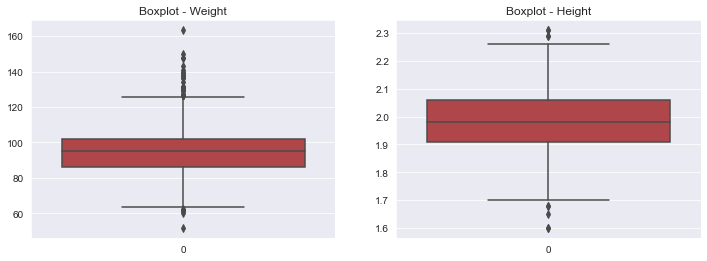

In [38]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (12,4))

# Ax 1 - Boxplot weight
sns.boxplot(data = NBA_hipotesis.weight_kg, ax=ax1)
ax1.set_title('Boxplot - Weight')

# Ax2 - Boxplot height
sns.boxplot(data = NBA_hipotesis.height_m, ax=ax2)
ax2.set_title('Boxplot - Height');


2) Representamos gráficamente peso vs altura.

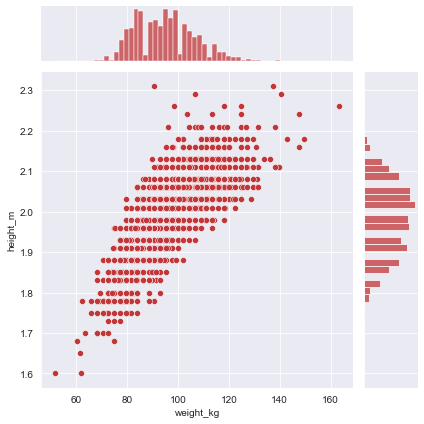

In [39]:
sns.jointplot(x = NBA_hipotesis.weight_kg,
                y = NBA_hipotesis.height_m)

3) Test de normalidad.

In [40]:
pg.normality(NBA_hipotesis, method = 'shapiro')

,W,pval,normal
height_m,0.987678,2.001095e-19,False
weight_kg,0.981540,8.088301e-24,False
birth_year,0.963346,2.247991e-32,False
Num_seasons,0.856541,0.000000e+00,False


Para probar la hipótesis de que dos variables, no normales y con outlaiers son independientes voy a usar el test de Shepherd que es un test de correlación robusta. Nuestra hipótesis quedaría formulada de la siguiente manera:

$H0: Las \ dos \ muestras \ son \ independientes. $

$H1: Existe \ dependencia \ entre \ muestras. $


In [41]:
pg.corr(x = NBA_hipotesis.height_m,
        y = NBA_hipotesis.weight_kg,
        method = 'shepherd')

,n,outliers,r,CI95%,p-val,power
shepherd,4514,209,0.856259,"[0.85, 0.86]",0.0,1.0


Valor P es menor que el nivel de significancia, por lo que puedo rechazar la hipótesis nula y afirmar que el **peso y la altura no son independientes.** 

## Nivell 3
### - Exercici 3

Continua amb el conjunt de dades de tema esportiu que t'agradi i selecciona tres atributs del conjunt de dades. Calcula el p-valor i digues si rebutja la hipòtesi nul·la agafant un alfa de 5%.

En esta ocasión quiero comprobar si las posiciones y la altura está relacionadas. Es decir, ¿tienen Bases (G o guard), aleros (F o forward) y pivots ( C o center) la misma altura?

Como nuestras distribuciones no habían pasado el test de shapiro recurriré a un test no paramétrico similar a un ANOVA, el test de la H de Kruskal-Wallis.

En este caso la hipótesis sería:

$H_0: \overline{X}_{C} = \overline{X}_{F} = \overline{X}_{G}$

$H_A: \overline{X}_{C} \neq \overline{X}_{F} \neq \overline{X}_{G} $

In [42]:
NBA_posiciones = NBA_hipotesis[NBA_hipotesis.position.isin(['C','G','F'])]

In [43]:
pg.kruskal(data = NBA_posiciones,
           dv = 'height_m',
           between = 'position')

,Source,ddof1,H,p-unc
Kruskal,position,2,2396.717699,0.0


Como obtengo un valor P menor de 0.05, puedo rechazar la hipótesis nula y afirmar que **bases, aleros y pivots tienen alturas diferentes**.  